In [1]:
from gym_minigrid.wrappers import *
from env import *
from memory import *
from agent import DQN

import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from itertools import count

device = torch.device("cuda:5")

class RandomAgent:
    def __init__(self, action_dim):
        self.action_dim = action_dim
    
    def step(self, observation=None):
        return np.random.randint(self.action_dim)

# [1,2,
#  3,4]
# 0-up, 1-right, 2-down, 3-left

# seed=32 for fourrooms in main.py

### env related stuff

In [2]:
# 0-left, 1-down, 2-right, 3-up OR
# 0-up, 1-right, 2-down, 3-left?

In [2]:
from main import train, test

In [3]:
task = EmptyGridTask(size=19,task_type='random-1-4-8-12',goalcond=True)
task.set_phase('test')
memory = RemergeMemory(hidden_size=3000, state_size=3000)
agent = DQN(state_dim=4,
            action_dim=4, 
            goalcond=True, 
            device=device, 
            memory=memory)
x = test(task, agent, num_episodes=10, use_remerge=False, max_steps=20, remember=True, explore=True)

In [4]:
test(task,
         agent,
         use_remerge=True,
         replan_prob=0.5, # TODO: change based on t
         subgoal_advance_prob=0.2,
         switch_goal_prob=0.5,
         plan_steps_test=4,
         recurrent_T_test=10,
         num_episodes=6,
         max_steps=20,
         remember=False,
         explore=True)

{'n_step': array([20., 20., 20., 20., 20., 20.]),
 'solved': array([0., 0., 0., 0., 0., 0.]),
 'reward': array([0., 0., 0., 0., 0., 0.]),
 'excess_steps': array([11., 11., 12.,  8., 12., 12.])}

In [35]:
task = FourRoomsTask(task_type='random',
                     reward_type='sparse', 
                     goalcond=True, 
                     seed=32)
# task.set_phase('test')
obs = task.reset()

In [46]:
# task = task.clone()
obs = task.reset()

In [51]:
# 0-left, 1-down, 2-right, 3-up
obs, r, done, _ = task.step(2)
print(r, done)

-1.0 False


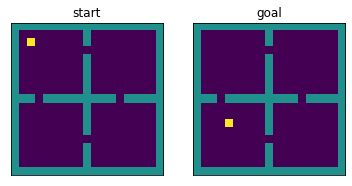

In [51]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(obs['image'][0])
axes[1].imshow(obs['goal'][0])
axes[0].set_title('start')
axes[1].set_title('goal')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
fig.savefig('4r.pdf')

In [87]:
0.05 + (0.9 - 0.05) * \
    math.exp(-1. * 700 / 250)

0.10168855323143527

#### memory related stuff

In [1]:
from gym_minigrid.wrappers import *
from env import *
from memory import *
from agent import DQN

import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from itertools import count

device = torch.device("cuda:5")

class RandomAgent:
    def __init__(self, action_dim):
        self.action_dim = action_dim
    
    def step(self, observation=None):
        return np.random.randint(self.action_dim)

# [1,2,
#  3,4]
# 0-up, 1-right, 2-down, 3-left

# seed=32 for fourrooms in main.py

In [2]:
np.set_printoptions(precision=2)

In [34]:
task = EmptyGridTask(size=19,
                     task_type='random-1-4-5-8',
                     reward_type='sparse',
                     goalcond=True)
ra = RandomAgent(4)

In [80]:
def gen_maze(pos):
    grid = np.array(task.env.grid.grid.copy())
    wall_mask = np.array([x is not None for x in grid])
    grid[wall_mask] = 1.0 # walls
    grid[~wall_mask] = 0.0 # open space
    grid = grid.reshape(19, 19).astype(np.float)
    grid[-2,-2] = 0.0 # overwrite default goal
    grid[pos[0], pos[1]] = 2.0 # agent
    
    return grid

In [21]:
tau = 0.4

netin = [0.01, 0.1, 1., 2., 3., 4.]
# netin = [0., 0., 1., 1., 0., 0.]
denom = np.sum([np.exp(x/tau) for x in netin])
act = np.array([np.exp(x/tau)/denom for x in netin])
print('softmax: ', ['%.2f'% x for x in act])
act = np.array([1/(1+np.exp(-x/tau)) for x in netin]) - 0.5
print('logistic: ', ['%.2f'% x for x in act])

softmax:  ['0.00', '0.00', '0.00', '0.01', '0.08', '0.92']
logistic:  ['0.01', '0.06', '0.42', '0.49', '0.50', '0.50']


In [6]:
grid = np.array(task.env.grid.grid.copy())
wall_mask = np.array([x is not None for x in grid])
grid[wall_mask] = 1.0 # walls
grid[~wall_mask] = 0.0 # open space
grid = grid.reshape(19, 19).astype(np.float)

In [7]:
grid.shape

(19, 19)

In [8]:
# collect some random transitions for prototyping
# 19*19*4*2=2888 unique links

memory = RemergeMemory(hidden_size=2000, state_size=2000)
# memory.links = pickle.load(open('all_links.pkl', 'rb'))
# memory.all_states = pickle.load(open('all_states.pkl', 'rb'))
# memory.attractor_network.weights = pickle.load(open('attrnet_weights.pkl','rb'))

# obs = task.reset()
# state = obs['state']

for i in range(19):
    for j in range(19):
        if grid[i,j] == 1.0:
            continue
        s = [i,j]
        for a in range(4):
            if a==0:
                ns = [i-1, j]
            if a==1:
                ns = [i+1, j]
            if a==2:
                ns = [i, j-1]
            if a==3:
                ns = [i, j+1]
            if (ns[0]>=0) and (ns[1]>=0) and (ns[0]<19) and (ns[1]<19):
                if grid[ns[0],ns[1]] == 0.0:
                    memory.add(s, a, 0, ns, goal=None)

# for i in range(30):
    
#     action = np.random.randint(4)
#     next_obs, reward, done, _ = task.step(action)
#     next_state = next_obs['state']

#     if done:
#         next_state = None

#     memory.add(state, action, reward, next_state, goal=obs['goal'])
    
#     if done:
#         obs = task.reset()
#         state = obs['state']
#     else:
#         state = next_state
        
#     if len(memory.links) > 30:
#         break

In [9]:
memory.wire_memory()

In [10]:
print(len(memory.links))

1084


In [11]:
print(len(memory.all_states))

288


In [35]:
task.set_phase('test')

In [60]:
obs = task.reset()
obs

{'state': array([ 2, 11]), 'goal': array([ 9, 12]), 'optim_step': 8}

In [70]:
# memory.plan(s_probe=[12,11], ns_probe=[4,14], n_level=2, T=4, mode='sample')
memory.plan(s_probe=obs['state'], ns_probe=obs['goal'], n_level=1, mode='sample')

([3, 11], [9, 13])

In [78]:
np.linspace(0.8, 0.1, num=16//2).tolist() + [0.0] * (16-16//2)

[0.8,
 0.7000000000000001,
 0.6000000000000001,
 0.5,
 0.4,
 0.30000000000000004,
 0.19999999999999996,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
'''
{'state': array([11,  7]), 'goal': array([9, 2]), 'optim_step': 7}
[array([11.,  8.], dtype=float32),
 array([10.,  8.], dtype=float32),
 array([10.,  3.], dtype=float32),
 array([9., 3.], dtype=float32)]

{'state': array([ 4, 15]), 'goal': array([ 2, 10]), 'optim_step': 7}
[array([ 4., 16.], dtype=float32),
 array([ 4., 15.], dtype=float32),
 array([ 2., 12.], dtype=float32),
 array([ 2., 11.], dtype=float32)]

{'state': array([ 6, 13]), 'goal': array([ 2, 11]), 'optim_step': 6}
[array([ 5., 13.], dtype=float32),
 array([ 5., 14.], dtype=float32),
 array([ 3., 12.], dtype=float32),
 array([ 2., 12.], dtype=float32)]

{'state': array([13,  3]), 'goal': array([9, 2]), 'optim_step': 5}
[array([14.,  3.], dtype=float32),
 array([13.,  3.], dtype=float32),
 array([10.,  3.], dtype=float32),
 array([9., 3.], dtype=float32)]

{'state': array([8, 1]), 'goal': array([9, 5]), 'optim_step': 5}
[array([9., 1.], dtype=float32),
 array([10.,  1.], dtype=float32),
 array([9., 1.], dtype=float32),
 array([9., 3.], dtype=float32),
 array([9., 4.], dtype=float32)]
 
 {'state': array([13,  9]), 'goal': array([11,  5]), 'optim_step': 6}
 [array([12.,  9.], dtype=float32),
 array([12., 10.], dtype=float32),
 array([12., 11.], dtype=float32),
 array([12.,  6.], dtype=float32),
 array([11.,  6.], dtype=float32)]
 
 {'state': array([14,  3]), 'goal': array([17,  6]), 'optim_step': 6}
 [array([14.,  4.], dtype=float32),
 array([14.,  3.], dtype=float32),
 array([14.,  4.], dtype=float32),
 array([16.,  5.], dtype=float32),
 array([17.,  5.], dtype=float32)]
 
 {'state': array([12, 10]), 'goal': array([ 9, 13]), 'optim_step': 6}
 [array([12., 11.], dtype=float32),
 array([11., 11.], dtype=float32),
 array([11., 12.], dtype=float32),
 array([ 7., 13.], dtype=float32),
 array([ 8., 13.], dtype=float32)]
'''

In [ ]:
{'state': array([8, 1]), 'goal': array([9, 5]), 'optim_step': 5}
[array([9., 1.], dtype=float32),
 array([10.,  1.], dtype=float32),
 array([9., 1.], dtype=float32),
 array([9., 3.], dtype=float32),
 array([9., 4.], dtype=float32)]

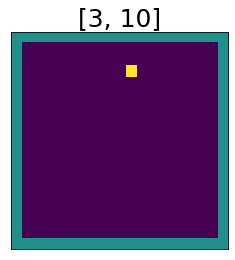

In [98]:
x = [3,10]

fig, ax = plt.subplots(1)
ax.imshow(gen_maze(x))
ax.set_title(x, fontsize=25)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [362]:
# need to double the size of transitions
rmm = RemergeMemory(hidden_size=50, state_size=50)
for x in memory.memory:
    rmm.add(x.state, x.action, x.reward, x.next_state, x.goal)

In [363]:
for i, l in enumerate(rmm.links):
    print('link %d'%i, end=':  ')
    s = l.state1
    ns = l.state2
    print(rmm.find_state(rmm.all_states, s),':',s, '-->', rmm.find_state(rmm.all_states, ns),':',ns)

link 0:  0 : [13. 11.] --> 1 : [13. 10.]
link 1:  1 : [13. 10.] --> 2 : [14. 10.]
link 2:  2 : [14. 10.] --> 1 : [13. 10.]
link 3:  1 : [13. 10.] --> 3 : [12. 10.]
link 4:  3 : [12. 10.] --> 4 : [12.  9.]
link 5:  4 : [12.  9.] --> 5 : [12.  8.]
link 6:  5 : [12.  8.] --> 6 : [12.  7.]
link 7:  6 : [12.  7.] --> 7 : [13.  7.]
link 8:  7 : [13.  7.] --> 8 : [13.  6.]
link 9:  8 : [13.  6.] --> 9 : [13.  5.]
link 10:  9 : [13.  5.] --> 10 : [12.  5.]
link 11:  10 : [12.  5.] --> 11 : [11.  5.]
link 12:  11 : [11.  5.] --> 12 : [11.  6.]
link 13:  12 : [11.  6.] --> 11 : [11.  5.]
link 14:  11 : [11.  5.] --> 13 : [10.  5.]
link 15:  13 : [10.  5.] --> 14 : [9. 5.]
link 16:  14 : [9. 5.] --> 15 : [9. 6.]
link 17:  15 : [9. 6.] --> 16 : [9. 7.]
link 18:  16 : [9. 7.] --> 17 : [8. 7.]
link 19:  17 : [8. 7.] --> 16 : [9. 7.]
link 20:  17 : [8. 7.] --> 18 : [7. 7.]
link 21:  18 : [7. 7.] --> 19 : [7. 8.]
link 22:  19 : [7. 8.] --> 18 : [7. 7.]
link 23:  18 : [7. 7.] --> 17 : [8. 7.]
link 24: 

In [369]:
s = rmm.links[16].state1
g = rmm.links[42].state2
print(rmm.find_state(rmm.all_states, s), ':', s, rmm.find_state(rmm.all_states, g), ':', g)

14 : [9. 5.] 33 : [2. 6.]


In [370]:
np.set_printoptions(precision=2)
plan = rmm.plan(s_probe=s, ns_probe=g, plan_steps=4, T=100, mode='sample')

plan_indexes:  [15, 16, 31, 32]


In [359]:
np.set_printoptions(precision=2)
plan = rmm.plan(s_probe=s, ns_probe=g, plan_steps=12, T=100, mode='sample')

plan_indexes:  [15, 16, 17, 18, 17, 18, 27, 28, 29, 30, 31, 32]
